# Обработка пропусков и выбросов в процессе первичного анализа статистики

### Disclaimer: 
_Представленные ниже примеры предназначены исключительно для демонстрации подходов к устранению аномалий в данных. Выбор подхода в "боевых условиях" должен осуществляеться в соответсвии с решаемыми задачами и с учетом особенностей формирования данных в исследуемом процессе_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Загрузка датасета

In [2]:
data = pd.read_csv("iris.csv")
data.tail(7)

,sepal.length,sepal.width,petal.length,petal.width,variety
143,6.8,3.2,5.9,2.3,Virginica
144,6.7,3.3,5.7,2.5,Virginica
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica
149,5.9,3.0,5.1,1.8,Virginica


### Добавляем немного NaN

In [3]:
data["petal.width"].iloc[145:149] = None
data.tail(7)

,sepal.length,sepal.width,petal.length,petal.width,variety
143,6.8,3.2,5.9,2.3,Virginica
144,6.7,3.3,5.7,2.5,Virginica
145,6.7,3.0,5.2,NaN,Virginica
146,6.3,2.5,5.0,NaN,Virginica
147,6.5,3.0,5.2,NaN,Virginica
148,6.2,3.4,5.4,NaN,Virginica
149,5.9,3.0,5.1,1.8,Virginica


## Построение гистограммы "petal.length"

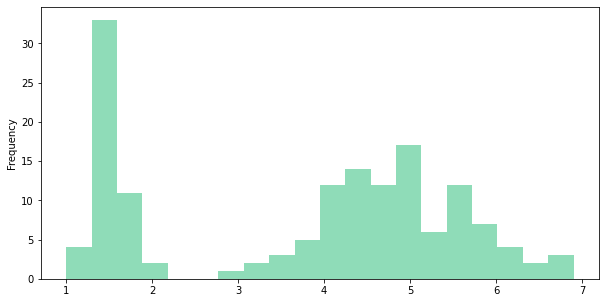

In [4]:
data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

### Есть выброс "petal.length" в диапазоне примерно 1..1.9

### Зафиксируем исходные данные до заполнения NaN 

In [5]:
with_outliers = data["petal.length"].head(20).copy()
before_NaN = data["petal.width"].iloc[25:42].copy()

### Заменяем  выброс "petal.length" расчетными данными

#### длина лепестка не может быть отрицательной!

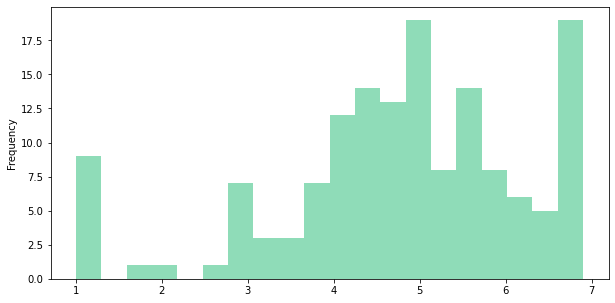

In [6]:
data["petal.length"][data["petal.length"]<=2.8] = np.clip(np.random.normal(loc= data["petal.length"][data["petal.length"]>=2.8].median(),
                                                        scale=data["petal.length"].var(), 
                                                        size=len(data["petal.length"][data["petal.length"]<=2.8])), 
                                                          data["petal.length"].min(),
                                                          data["petal.length"].max())
data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [7]:
### снова выбросы :-(
### убираем выброс минимумов ...

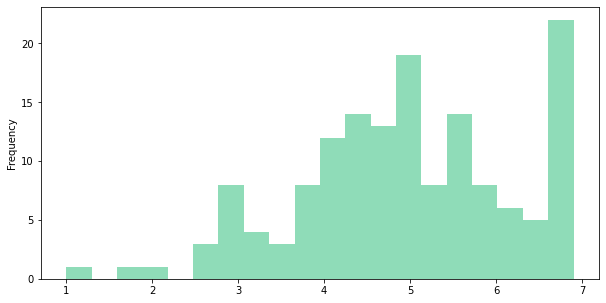

In [8]:
data["petal.length"][data["petal.length"]==data["petal.length"].min()] = np.clip(np.random.normal(loc= data["petal.length"].median(),
                                                        scale=data["petal.length"].var(), 
                                                        size=len(data["petal.length"][data["petal.length"]==data["petal.length"].min()]) ), 
                                                          data["petal.length"].min(),
                                                          data["petal.length"].max())



data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

### ... и убираем выброс максимумов 

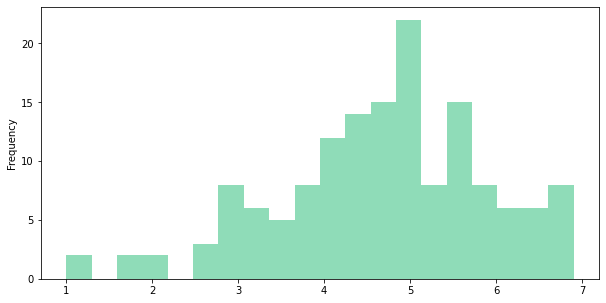

In [9]:
data["petal.length"][data["petal.length"]==data["petal.length"].max()] = np.clip(np.random.normal(loc= data["petal.length"].median(),
                                                        scale=data["petal.length"].var(), 
                                                        size=len(data["petal.length"][data["petal.length"]==data["petal.length"].max()]) ), 
                                                          data["petal.length"].min(),
                                                          data["petal.length"].max())
data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [10]:
display(pd.DataFrame(list(zip(with_outliers, data["petal.length"].head(20))),
                   columns=["With_outliers", "After_norm"]))

,With_outliers,After_norm
0,1.4,1.871728
1,1.4,6.272126
2,1.3,2.870730
3,1.5,1.000000
4,1.4,4.947510
5,1.7,6.896265
6,1.4,6.625386
7,1.5,5.701014
8,1.4,2.534379
9,1.5,4.844766


###### Выброс исчез

## Построение гистограмы для "petal.width"

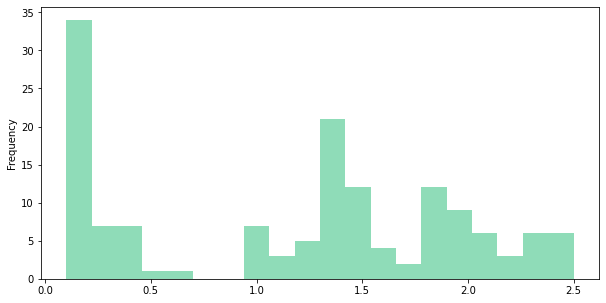

In [11]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

### убеждаемся в наличии NaN

In [12]:
data["petal.width"][data["petal.width"].isnull()]

145   NaN
146   NaN
147   NaN
148   NaN
Name: petal.width, dtype: float64

### Заполняем пропуски

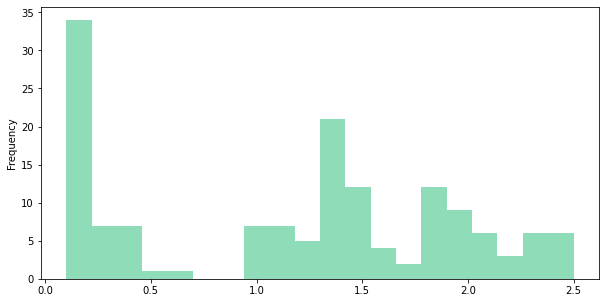

In [13]:
# используем std()
data["petal.width"].fillna(data["petal.width"].mean() 
                           + data["petal.width"].std()*np.random.randint(low=-1, high=2, size=1)[0], # ограничиваем отклонение
                          inplace=True)
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [14]:
data["petal.width"].tail(7)

143    2.300000
144    2.500000
145    1.173973
146    1.173973
147    1.173973
148    1.173973
149    1.800000
Name: petal.width, dtype: float64

### добавим еще пропусков (примерно 1/6)
### и проверим результаты по критерию $\chi^2$

array([21.,  5.,  5.,  1.,  1.,  0.,  0.,  7.,  7.,  5., 20., 11.,  3.,
        2.,  7.,  7.,  5.,  2.,  5.,  5.])

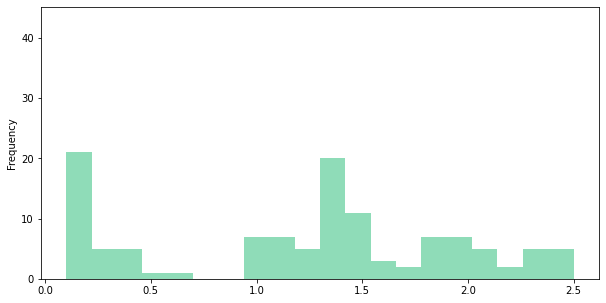

In [15]:
data["petal.width"].iloc[125:139] = None
data["petal.width"].iloc[25:42] = None
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

# фиксируем значения гистограммы (с разными BINS)
b_before, n_before, _ = plt.hist(data["petal.width"], bins=20, visible=False);
b2 = 5
b_before_2, n_before_2, _ = plt.hist(data["petal.width"], bins=b2, visible=False);

# значения столбиков гистограммы
b_before

In [16]:
data["petal.width"].iloc[25:42]

25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
31   NaN
32   NaN
33   NaN
34   NaN
35   NaN
36   NaN
37   NaN
38   NaN
39   NaN
40   NaN
41   NaN
Name: petal.width, dtype: float64

### Подготовка корректирующих значений

In [17]:
df_corr = pd.DataFrame(np.random.normal(loc=data["petal.width"].mean(),
                                scale=data["petal.width"].var(), 
                                size=len(data["petal.width"])),
                      columns = ["petal.width"]) 
                                
df_corr                      

,petal.width
0,1.371639
1,1.569335
2,1.328768
3,0.882280
4,1.330694
...,...
145,-0.062309
146,0.810936
147,0.747112
148,1.416626


In [18]:
df_corr.min() # больше нуля :-)

petal.width   -0.062309
dtype: float64

### Заполняем пропуски

In [19]:
data.fillna(value=df_corr, inplace=True)
display(pd.DataFrame(list(zip(before_NaN, data["petal.width"].iloc[25:42])),
                   columns=["before_set_NaN", "After_filling"]))

,before_set_NaN,After_filling
0,0.2,0.169595
1,0.4,1.939555
2,0.2,0.780740
3,0.2,0.938038
4,0.2,0.985608
5,0.2,0.726444
6,0.4,2.032924
7,0.1,1.960808
8,0.2,1.394276
9,0.2,0.879221


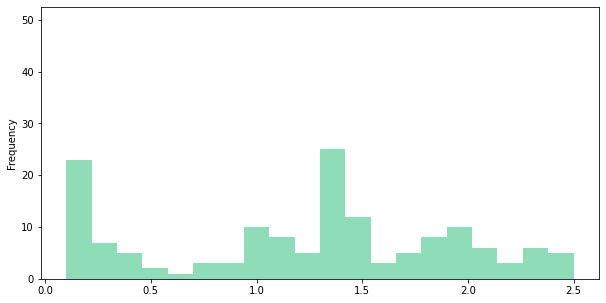

In [20]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20, );
# получаем параметры гистограммы c bins = 20
b_after, n_after, _ = plt.hist(data["petal.width"], bins=20, visible=False);
# и bins = b2
b_after_2, n_after_2, _ = plt.hist(data["petal.width"], bins=b2, visible=False);

### Почти похоже на исходный :-)

#### ... но так ли это
#### используем критерий $\chi^2$

In [21]:
import scipy
scipy.__version__

'1.6.3'

In [22]:
# сравниваем методом хи-квадрат
from scipy.stats import chisquare, chi2_contingency
print (f"ДО\n {b_before} \nПОСЛЕ\n {b_after}")
_, p_value = chisquare(chisquare(b_before, b_after, ddof=len(b_after)-1))

print(f"p_value = {p_value}")

ДО
 [21.  5.  5.  1.  1.  0.  0.  7.  7.  5. 20. 11.  3.  2.  7.  7.  5.  2.
  5.  5.] 
ПОСЛЕ
 [23.  7.  5.  2.  1.  3.  3. 10.  8.  5. 25. 12.  3.  5.  8. 10.  6.  3.
  6.  5.]
p_value = nan


#### меняем bins

In [23]:
print (f"ДО\n {b_before_2} \nПОСЛЕ\n {b_after_2}")
#stat, p_value_2, dof, _= chi2_contingency([b_before_2, b_after_2])
_, p_value_2 = chisquare(b_before_2, b_after_2, ddof=len(b_after_2)-1)

print(f"p_value = {p_value_2}")

ДО
 [32.  8. 43. 19. 17.] 
ПОСЛЕ
 [37. 17. 50. 26. 20.]
p_value = nan


#### _...нужен иной подход ?_


### Снова генерируем пропуски, но в этот раз удаляем 

In [24]:
data["petal.width"].iloc[125:147] = None
data.tail(10)

,sepal.length,sepal.width,petal.length,petal.width,variety
140,6.7,3.1,5.6,NaN,Virginica
141,6.9,3.1,5.1,NaN,Virginica
142,5.8,2.7,5.1,NaN,Virginica
143,6.8,3.2,5.9,NaN,Virginica
144,6.7,3.3,5.7,NaN,Virginica
145,6.7,3.0,5.2,NaN,Virginica
146,6.3,2.5,5.0,NaN,Virginica
147,6.5,3.0,5.2,1.173973,Virginica
148,6.2,3.4,5.4,1.173973,Virginica
149,5.9,3.0,5.1,1.800000,Virginica


In [25]:
data.dropna(inplace=True)
data.tail(10)

,sepal.length,sepal.width,petal.length,petal.width,variety
118,7.7,2.6,3.081171,2.300000,Virginica
119,6.0,2.2,5.000000,1.500000,Virginica
120,6.9,3.2,5.700000,2.300000,Virginica
121,5.6,2.8,4.900000,2.000000,Virginica
122,7.7,2.8,6.700000,2.000000,Virginica
123,6.3,2.7,4.900000,1.800000,Virginica
124,6.7,3.3,5.700000,2.100000,Virginica
147,6.5,3.0,5.200000,1.173973,Virginica
148,6.2,3.4,5.400000,1.173973,Virginica
149,5.9,3.0,5.100000,1.800000,Virginica


### "Пропали" все строки с пропусками

## Заполняем смешанные пропуски
#### ...но сначала их создадим ))

In [26]:
display(data.head())
data.iloc[0:3] = None
display(data.head())

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.871728,0.2,Setosa
1,4.9,3.0,6.272126,0.2,Setosa
2,4.7,3.2,2.870730,0.2,Setosa
3,4.6,3.1,1.000000,0.2,Setosa
4,5.0,3.6,4.947510,0.2,Setosa


,sepal.length,sepal.width,petal.length,petal.width,variety
0,NaN,NaN,NaN,NaN,None
1,NaN,NaN,NaN,NaN,None
2,NaN,NaN,NaN,NaN,None
3,4.6,3.1,1.00000,0.2,Setosa
4,5.0,3.6,4.94751,0.2,Setosa


In [27]:
values = {"sepal.length": data["sepal.length"][data["variety"]=="Setosa"].mean(),
          "sepal.width": data["sepal.width"][data["variety"]=="Setosa"].mean(), 
          "petal.length": data["petal.length"][data["variety"]=="Setosa"].median(), 
          "petal.width": data["petal.width"][data["variety"]=="Setosa"].median(),
          "variety": "Setosa"}
data.fillna(value=values, inplace=True)
display(data.head())

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.012766,3.440426,4.65850,0.3,Setosa
1,5.012766,3.440426,4.65850,0.3,Setosa
2,5.012766,3.440426,4.65850,0.3,Setosa
3,4.600000,3.100000,1.00000,0.2,Setosa
4,5.000000,3.600000,4.94751,0.2,Setosa


## Extra case. Infinity

In [28]:
data["petal.width"].iloc[15:19] = np.array((np.inf, -np.inf, np.inf, np.log(0)))
data.iloc[15:19]

,sepal.length,sepal.width,petal.length,petal.width,variety
15,5.7,4.4,2.585075,inf,Setosa
16,5.4,3.9,2.992773,-inf,Setosa
17,5.1,3.5,3.196698,inf,Setosa
18,5.7,3.8,2.824056,-inf,Setosa


### Гистограмма не строится при наличии inf

In [29]:
data["petal.width"].describe()

count    128.000
mean         NaN
std          NaN
min         -inf
25%        0.575
50%        1.300
75%        1.725
max          inf
Name: petal.width, dtype: float64

In [30]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );
# Ой! Что-то пойшло не так!

ValueError: autodetected range of [-inf, inf] is not finite

## Заменяем inf и -inf на NaN

In [31]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.iloc[14:20]

,sepal.length,sepal.width,petal.length,petal.width,variety
14,5.8,4.0,6.900000,0.2,Setosa
15,5.7,4.4,2.585075,NaN,Setosa
16,5.4,3.9,2.992773,NaN,Setosa
17,5.1,3.5,3.196698,NaN,Setosa
18,5.7,3.8,2.824056,NaN,Setosa
19,5.1,3.8,4.994304,0.3,Setosa


### а дальше дело техники...

# Устранение пропусков в линиях/рядах

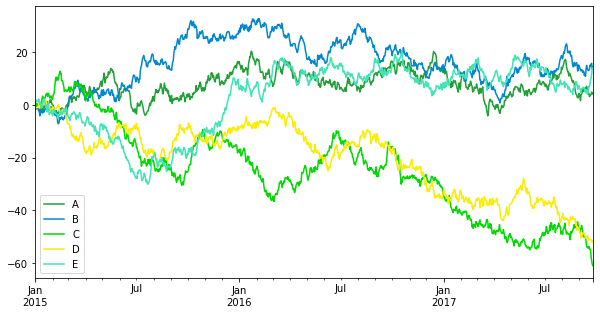

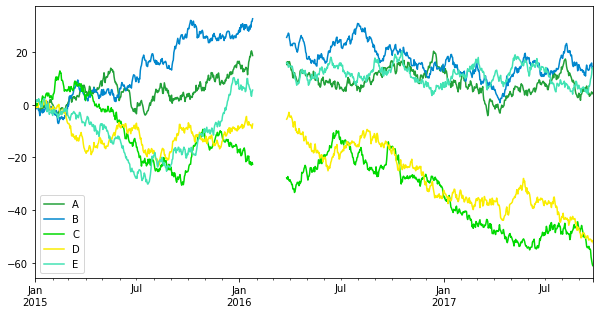

In [32]:
sbercolors = ['#21A038','#0087CD','#00D900', '#FAED00',  '#42E3B4','#21BA72'] 
image_params = dict(figsize=(10,5), 
                color=sbercolors)
samples = np.random.randn(1000, 5)

df = pd.DataFrame(samples, 
                   index=pd.date_range("1/1/2015", periods=1000),
                   columns=list("ABCDE"))
df = df.cumsum()
df.plot(**image_params);    
before = df.iloc[400:420].copy()        
df.iloc[390:450] = None

df.plot(**image_params);
  

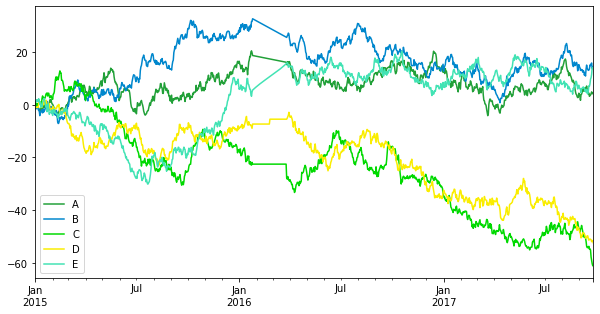

In [33]:
to_fill = {"A": df["A"].interpolate(method='linear'),
           "B": df["B"].interpolate(method='time'),
           "C": df["C"].interpolate(method='pad'),
           "D": df["D"].interpolate(method='nearest'),
           "E": df["E"].interpolate(method='akima'),}
df.fillna(value=to_fill, inplace=True)
df.plot(**image_params);


In [34]:
to_check = pd.concat((before,df.iloc[400:420]), axis=1)
to_check.columns = pd.MultiIndex.from_product([['Before', 'Recycled'], df.columns,],
                                     names=['subject', 'type'])

display(to_check) 

subject        Before                                             Recycled  \
type                A          B          C         D         E          A   
2016-02-05  17.105977  32.010580 -26.804569 -7.735545  5.453295  18.184046   
2016-02-06  15.453139  32.716246 -27.375467 -6.505845  4.198479  18.141666   
2016-02-07  14.081562  31.684979 -27.350703 -5.984098  3.344913  18.099286   
2016-02-08  12.350574  30.554951 -26.860155 -6.704818  2.371942  18.056907   
2016-02-09  12.365011  29.509069 -28.365860 -5.904961  2.124525  18.014527   
2016-02-10  12.355101  29.404460 -28.666476 -6.407138  2.309518  17.972147   
2016-02-11  12.726120  29.971671 -29.218129 -6.681768  1.143903  17.929768   
2016-02-12  12.492835  30.461473 -27.898503 -6.329226  2.942598  17.887388   
2016-02-13  11.665553  30.593479 -28.190413 -6.628508  3.783371  17.845008   
2016-02-14   9.931811  29.784172 -30.479837 -6.094357  5.247566  17.802629   
2016-02-15  10.473589  31.262473 -31.917403 -6.031808  5.969272  17.760249   
2016-02-16  10.801221  30.904545 -32.870063 -6.889739  5.235813  17.717869   
2016-02-17   9.829133  30.818530 -32.804295 -6.949351  7.454890  17.675490   
2016-02-18  12.107448  30.513967 -32.342671 -6.432569  8.147285  17.633110   
2016-02-19  11.814419  29.126924 -34.169875 -7.389027  8.215210  17.590730   
2016-02-20  11.941967  27.647741 -33.402169 -8.059054  8.448980  17.548351   
2016-02-21  11.699291  25.813873 -34.122462 -6.980371  8.167338  17.505971   
2016-02-22  13.082269  25.489868 -34.913117 -7.268341  8.138952  17.463592   
2016-02-23  13.524691  25.702218 -33.692719 -6.416939  6.893974  17.421212   
2016-02-24  11.941634  25.524422 -34.170100 -5.205622  7.343663  17.378832   

subject                                                
type                B          C         D          E  
2016-02-05  31.307813 -22.518197 -7.327716   7.548242  
2016-02-06  31.191943 -22.518197 -7.327716   7.716812  
2016-02-07  31.076072 -22.518197 -7.327716   7.883478  
2016-02-08  30.960202 -22.518197 -7.327716   8.048348  
2016-02-09  30.844332 -22.518197 -7.327716   8.211525  
2016-02-10  30.728462 -22.518197 -7.327716   8.373115  
2016-02-11  30.612592 -22.518197 -7.327716   8.533224  
2016-02-12  30.496721 -22.518197 -7.327716   8.691956  
2016-02-13  30.380851 -22.518197 -7.327716   8.849418  
2016-02-14  30.264981 -22.518197 -7.327716   9.005714  
2016-02-15  30.149111 -22.518197 -7.327716   9.160951  
2016-02-16  30.033241 -22.518197 -7.327716   9.315232  
2016-02-17  29.917370 -22.518197 -7.327716   9.468664  
2016-02-18  29.801500 -22.518197 -7.327716   9.621352  
2016-02-19  29.685630 -22.518197 -7.327716   9.773401  
2016-02-20  29.569760 -22.518197 -7.327716   9.924917  
2016-02-21  29.453890 -22.518197 -7.327716  10.076005  
2016-02-22  29.338019 -22.518197 -7.327716  10.226769  
2016-02-23  29.222149 -22.518197 -7.327716  10.377317  
2016-02-24  29.106279 -22.518197 -7.327716  10.527752

#### Проверим точность восстановления по критерию $\chi^2$

In [35]:
for litera in "ABCDE":
    stat, p_value = chisquare([to_check["Before", litera].abs(),  ## Только положительные заначения!!!
                               to_check["Recycled",litera].abs()])
    display(f"{litera}: {np.mean(p_value)}") 

'A: 0.34330215535495484'

'B: 0.8564130341831158'

'C: 0.2917350937933485'

'D: 0.8264053343766404'

'E: 0.3727298326133487'

#### или просто посчитаем погрешность

In [36]:
# set colors for min, max. average values
color_set = pd.DataFrame({"Colors":("MAX", "MIN", "AVERAGE")})

def highlight_fill(s):
    colors =  ['background-color: #42E3B4',
            'background-color: #0087CD',
             'background-color: #FAED00']
    return [colors[0] if i==0 else  colors[1] if i==1 else colors[2] for i in range(len(s))]


color_set = color_set.style.apply(highlight_fill)
display(color_set)

# count accurancy values

accurancy = pd.concat( (before-df.iloc[400:420],
                       pow((before-df.iloc[400:420]),2)), axis=1) 
accurancy.columns = pd.MultiIndex.from_product([['ABS', 'SQR'], df.columns,],
                                     names=['subject', 'type'])
# adding a row
accurancy.loc[-1] = [accurancy[a_s].mean() for a_s in accurancy.columns[:5].tolist()] +\
                    [np.sqrt(accurancy[a_s].sum()/(len(accurancy)-1)) for a_s in accurancy.columns[5:].tolist()]  

def highlight_diff_max(s):
    if max(abs(s))==max(s): 
        idx = s.tolist().index(max(abs(s)))
    elif max(abs(s))!=max(s):
        idx = s.tolist().index(max(s))
    return ['background-color: #42E3B4' if i==idx else '' for i in range(len(s))]

def highlight_diff_min(s):
    if min(abs(s))==min(s): 
        idx = s.tolist().index(min(abs(s)))
    elif min(abs(s))!=min(s):
        idx = s.tolist().index(min(s))
    return ['background-color: #0087CD' if i==idx else '' for i in range(len(s))]

def highlight_last_row(s):
    return ['background-color: #FAED00' if i==len(s)-1 else '' for i in range(len(s))]

accurancy = accurancy.style.apply(highlight_last_row).apply(highlight_diff_max).apply(highlight_diff_min)
accurancy


,Colors
0,MAX
1,MIN
2,AVERAGE


### Красиво сохраняем...

In [37]:
type(accurancy)

pandas.io.formats.style.Styler

In [38]:
accurancy.to_excel("accurancy.xlsx") # xlsx only !!!!!!!!